# Рекуррентные нейронные сети

https://cnvrg.io/pytorch-lstm/

https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7

https://medium.com/analytics-vidhya/pytorch-for-deep-learning-lstm-for-sequence-data-d0708fdf5717

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

Будем предсказывать поток пассажиров авиакомпании

In [2]:
training_set = pd.read_csv(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
)

Как всегда визуализация

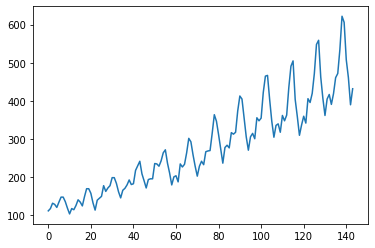

In [3]:
training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label='Данные о пассажирах авиакомпаний')
plt.show()

Что с размерностью?

In [4]:
training_set.shape

(144, 1)

Немного магии

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(training_set)

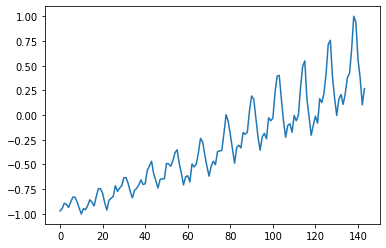

In [6]:
plt.plot(data, label='Данные о пассажирах авиакомпаний')
plt.show()

Подготовим данные к подаче в LSTM сеть

In [7]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [8]:
x, y = sliding_window(data, 4)

In [10]:
print(f'{x.shape = }')
print(f'{y.shape = }')

SyntaxError: ignored

Сразу разделим на обучающую и тренировочную

In [11]:
train_size = int(y.shape[0] * 0.67)
test_size = y.shape[0] - train_size

data_x = torch.Tensor(np.array(x))
data_y = torch.Tensor(np.array(y))

train_x = torch.Tensor(np.array(x[0: train_size]))
train_y = torch.Tensor(np.array(y[0: train_size]))

test_x = torch.Tensor(np.array(x[train_size:len(x)]))
test_y = torch.Tensor(np.array(y[train_size:len(y)]))

In [12]:
print(f'{train_x.shape = }')
print(f'{train_y.shape = }')
print(f'{test_x.shape = }')
print(f'{test_y.shape = }')

SyntaxError: ignored

Создадим нашу сеть

In [13]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=4):
        super().__init__()
        self.hidden_layers = hidden_layers
        # self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        # self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=hidden_layers,
            num_layers=1, batch_first=True
        )
        self.fc = nn.Linear(self.hidden_layers, 1)
        # self.model = nn.Sequential(
        #     nn.LSTMCell(1, self.hidden_layers),
        #     nn.LSTMCell(self.hidden_layers, self.hidden_layers),
        #     nn.Linear(self.hidden_layers, 1)
        # )

    def forward(self, x):
        # скрытое состояние для каждого узла в сети (первая ячейка)
        h_t = Variable(torch.zeros(1, x.size(0), self.hidden_layers))
        # состояние узла в сети (первая ячейка)
        c_t = Variable(torch.zeros(1, x.size(0), self.hidden_layers))

        # Распространение ввода через LSTM
        _, (h_out, _) = self.lstm(x, (h_t, c_t))

        h_out = h_out.view(-1, self.hidden_layers)

        out = self.fc(h_out)

        return out

Обучим

In [14]:
num_epochs = 2000
learning_rate = 0.01

lstm = LSTM()

criterion = torch.nn.MSELoss()  # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(train_x)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, train_y)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Эпоха: %d, loss: %1.5f" % (epoch, loss.item()))

Эпоха: 0, loss: 0.66282
Эпоха: 100, loss: 0.03615
Эпоха: 200, loss: 0.01245
Эпоха: 300, loss: 0.00869
Эпоха: 400, loss: 0.00739
Эпоха: 500, loss: 0.00666
Эпоха: 600, loss: 0.00640
Эпоха: 700, loss: 0.00633
Эпоха: 800, loss: 0.00629
Эпоха: 900, loss: 0.00625
Эпоха: 1000, loss: 0.00621
Эпоха: 1100, loss: 0.00618
Эпоха: 1200, loss: 0.00615
Эпоха: 1300, loss: 0.00614
Эпоха: 1400, loss: 0.00610
Эпоха: 1500, loss: 0.00607
Эпоха: 1600, loss: 0.00605
Эпоха: 1700, loss: 0.00600
Эпоха: 1800, loss: 0.00595
Эпоха: 1900, loss: 0.00588


Проверим что получилось

In [ ]:
lstm.eval()

# predict on training and test data
all_predict = lstm(data_x)

data_predict = all_predict.data.numpy()
data_y_plot = data_y.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
data_y_plot = scaler.inverse_transform(data_y_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='Граница обучения')

plt.plot(data_y_plot, label='Исходные данные')
plt.plot(data_predict, label='Предсказание')
plt.suptitle('Прогноз пассажиров авиаперевозок')
plt.legend()
plt.show()